In [1]:
import pandas as pd
import numpy as np
import os
from utils import DS_PATH
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [2]:
TRACKS_PATH = os.path.join(DS_PATH, 'tracks_filtered_dummies.csv')
tracks = pd.read_csv(TRACKS_PATH, index_col=0)
tracks.head(10)

,Chip Music,Electronic,Experimental,Folk,Garage,Hip-Hop,Indie-Rock,Instrumental,International,Pop,Punk,Rock
track_id,,,,,,,,,,,,
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,1,0,0
134,0,0,0,0,0,1,0,0,0,0,0,0
136,0,0,0,0,0,0,0,0,0,0,0,1
139,0,0,0,1,0,0,0,0,0,0,0,0
140,0,0,0,1,0,0,0,0,0,0,0,0
141,0,0,0,1,0,0,0,0,0,0,0,0


(128, 130)


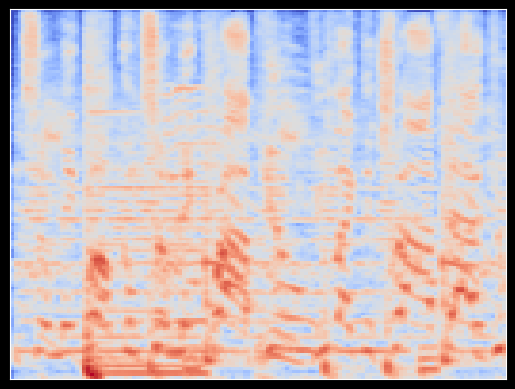

(128, 130)


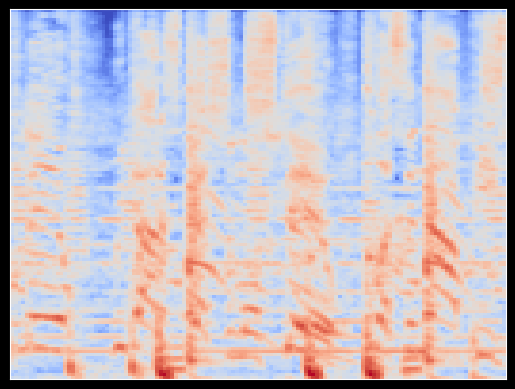

(128, 130)


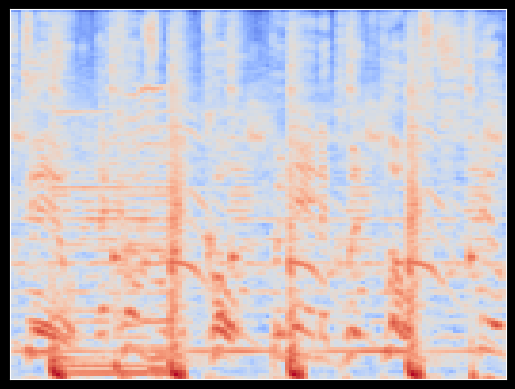

(128, 130)


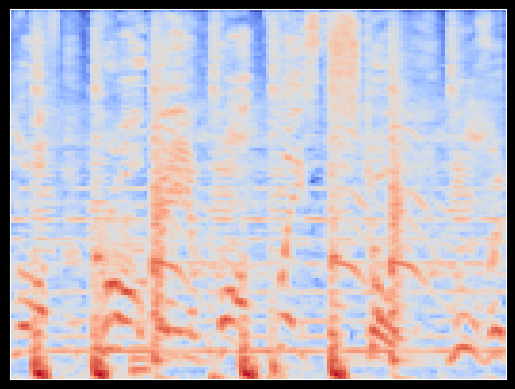

(128, 130)


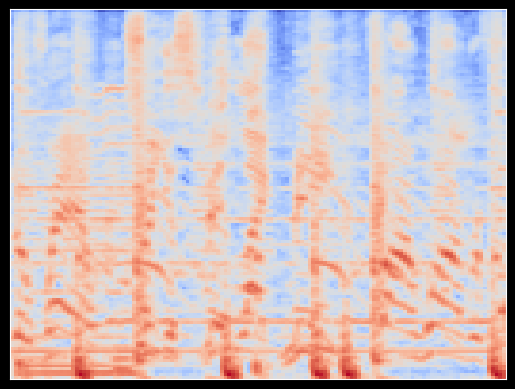

(128, 130)


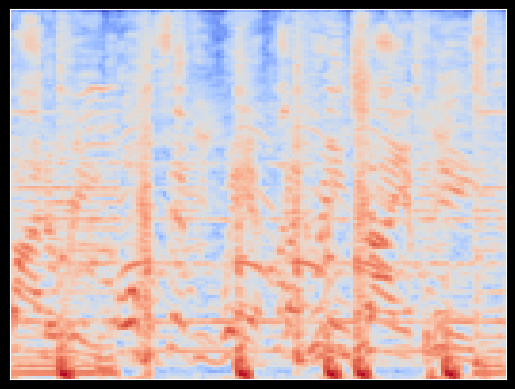

(128, 130)


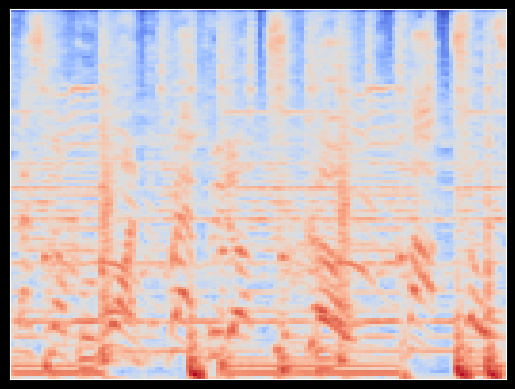

(128, 130)


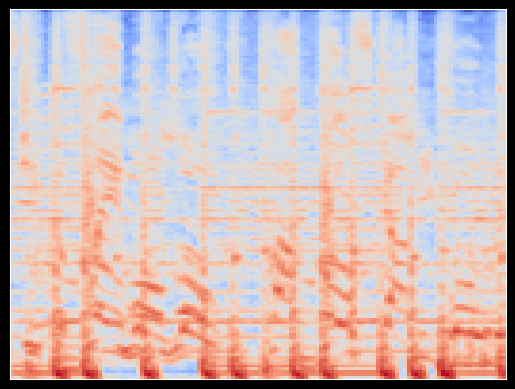

(128, 130)


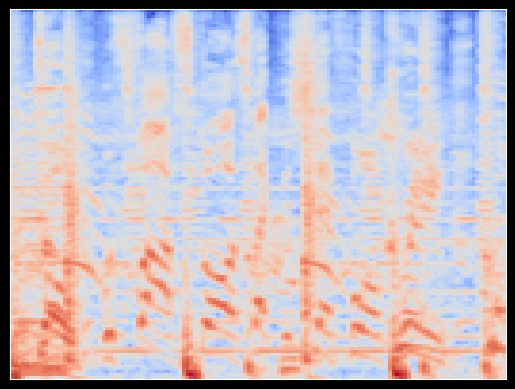

(128, 130)


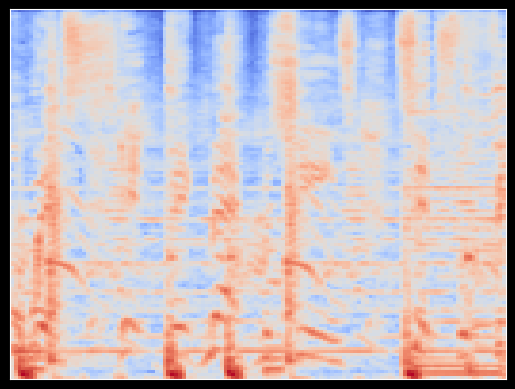

In [3]:
from librosa.display import specshow
from spectrograms import load_audio_file, generate_track_melspectrograms, N_FFT, SAMPLING_RATE, HOP_LENGTH

audio, sr = load_audio_file(2)
for spectrogram in generate_track_melspectrograms(audio):
    specshow(
        spectrogram, sr=SAMPLING_RATE,
        hop_length=HOP_LENGTH, n_fft=N_FFT)
    print(spectrogram.shape)
    plt.show()

In [4]:
labels = tracks.columns
labels_count = len(labels)
labels_count, labels

(12,
 Index(['Chip Music', 'Electronic', 'Experimental', 'Folk', 'Garage', 'Hip-Hop',
        'Indie-Rock', 'Instrumental', 'International', 'Pop', 'Punk', 'Rock'],
       dtype='object'))

In [5]:
del tracks

In [6]:
SPECTROGRAMS_PATH = os.path.join(os.getcwd(), 'pickled_spectrograms')
SPLIT_DURATION = 3.0

def get_set(
        set_name: str,
        spectrograms_path: str = SPECTROGRAMS_PATH,
        duration: float = SPLIT_DURATION
    ) -> np.ndarray:
    set_file_path = os.path.join(spectrograms_path, f'{set_name}_{duration}s.npz')
    return np.load(set_file_path, mmap_mode='r')

In [7]:
train_set = get_set('train')
x_train = train_set['X']
y_train = train_set['y']
del train_set
x_train.shape, y_train.shape

((167117, 128, 130), (167117, 12))

In [8]:
np.unique(y_train.argmax(axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [9]:
max_value = np.max(x_train)
max_value

42.7

In [10]:
input_shape = x_train[0].shape
input_shape

(128, 130)

In [11]:
from cnn_models import (
    compile_model, train_models,
    SpectrogramGenerator
)

BATCH_SIZE = 512

training_data_generator = SpectrogramGenerator(x_train, y_train, batch_size=512)
del x_train, y_train

In [12]:
val_set = get_set('validation')
x_val = val_set['X']
y_val = val_set['y']
del val_set
x_val.shape, y_val.shape

((48010, 128, 130), (48010, 12))

In [13]:
np.unique(y_val.argmax(axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [14]:
validation_data_generator = SpectrogramGenerator(x_val, y_val, batch_size=BATCH_SIZE)
del x_val, y_val

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Rescaling

input = Input((*input_shape, 1))

model1 = Sequential([
    input,
    Rescaling(1. / max_value),
    Conv2D(16, kernel_size=2, strides=2, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, kernel_size=2, strides=2, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, kernel_size=2, strides=2, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(labels_count, activation='softmax')
])

model1 = compile_model(model1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 130, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 65, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          2

In [16]:
model2 = Sequential([
    input,
    Rescaling(1 / max_value),

    Conv2D(16, kernel_size=(3, 1), strides=2),
    Conv2D(32, kernel_size=(3, 1), strides=2),
    MaxPooling2D(),

    Conv2D(32, kernel_size=(3, 1), strides=2),
    Conv2D(64, kernel_size=(3, 1), strides=2),
    MaxPooling2D(),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(labels_count, activation='softmax'),
])

model2 = compile_model(model2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 130, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 65, 16)        64        
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 33, 32)        1568      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 8, 32)          3104      
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 4, 64)          6208      
                                                      

In [17]:
model3 = Sequential([
    input,
    Rescaling(1 / max_value),

    Conv2D(32, kernel_size=(2, 1), strides=1),
    Conv2D(32, kernel_size=(2, 1), strides=1),
    MaxPooling2D(),

    Conv2D(64, kernel_size=(2, 1), strides=1),
    Conv2D(64, kernel_size=(2, 1), strides=1),
    MaxPooling2D(),

    Conv2D(128, kernel_size=(2, 1), strides=1),
    Conv2D(128, kernel_size=(2, 1), strides=1),
    MaxPooling2D(),

    Conv2D(256, kernel_size=(2, 1), strides=1),
    Conv2D(256, kernel_size=(2, 1), strides=1),
    MaxPooling2D(),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(labels_count, activation='softmax'),
])

model3 = compile_model(model3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 130, 1)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 127, 130, 32)      96        
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 130, 32)      2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 65, 64)        4160      
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 65, 64)        8256      
                                                      

In [18]:
models = {
    'model1': model1,
    'model2': model2,
    'model3': model3
}

In [19]:
models = train_models(
    models,
    training_data_generator,
    'accuracy',
    validation_data_generator,
    batch_size=BATCH_SIZE,
    epochs=150
)

Model model1
Epoch 1/150


326/326 [==============================] - 19s 50ms/step - loss: 2.1200 - accuracy: 0.2704 - val_loss: 1.9246 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 2/150
326/326 [==============================] - 18s 56ms/step - loss: 1.9410 - accuracy: 0.3213 - val_loss: 1.8431 - val_accuracy: 0.3522 - lr: 0.0010
Epoch 3/150
326/326 [==============================] - 18s 56ms/step - loss: 1.8742 - accuracy: 0.3464 - val_loss: 1.7854 - val_accuracy: 0.3795 - lr: 0.0010
Epoch 4/150
326/326 [==============================] - 18s 55ms/step - loss: 1.8375 - accuracy: 0.3628 - val_loss: 1.7646 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 5/150
326/326 [==============================] - 18s 56ms/step - loss: 1.8144 - accuracy: 0.3702 - val_loss: 1.7385 - val_accuracy: 0.3956 - lr: 0.0010
Epoch 6/150
326/326 [==============================] - 18s 55ms/step - loss: 1.7915 - accuracy: 0.3791 - val_loss: 1.7250 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 7/150
326/326 [==============================] - 18s 55ms/

: 

: 

In [ ]:
test_set = get_set('test')
x_test = test_set['X']
y_test = test_set['y']
del test_set
x_test.shape, y_test.shape

((23619, 128, 130), (23619, 12))

In [ ]:
test_data_generator = SpectrogramGenerator(x_train, y_train, batch_size=BATCH_SIZE, to_fit=False)
del x_train, y_train